# Predicting interest rates from Federal Reserve documents
## Baseline Definition (Vol. 5)
FE 690: Machine Learning in Finance \\
Author: Theo Dimitrasopoulos \\
Advisor: Zachary Feinstein \\

## Setup and loading data

In [1]:
import os
import sys
IN_COLAB = 'google.colab' in sys.modules
IN_COLAB

True

In [2]:
if IN_COLAB:
  from google.colab import drive
  drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
#if IN_COLAB:
  # Uninstall existing versions:
  #!pip uninstall bs4 -y
  #!pip uninstall textract -y
  #!pip uninstall numpy -y
  #!pip uninstall pandas -y
  #!pip uninstall requests -y
  #!pip uninstall tqdm -y
  #!pip uninstall nltk -y
  #!pip uninstall quandl -y
  #!pip uninstall scikit-plot -y
  #!pip uninstall seaborn -y
  #!pip uninstall sklearn -y
  #!pip uninstall torch -y
  #!pip uninstall transformers -y
  #!pip uninstall wordcloud -y
  #!pip uninstall xgboost -y

  # Install packages:
  #!pip install bs4==0.0.1
  #!pip install textract==1.6.3
  #!pip install numpy==1.19.4
  #!pip install pandas==1.1.4
  #!pip install requests==2.24.0
  #!pip install tqdm==4.51.0
  #!pip install nltk==3.5
  #!pip install quandl==3.5.3
  #!pip install scikit-plot==0.3.7
  #!pip install seaborn==0.11.0
  #!pip install sklearn==0.0
  #!pip install torch
  #!pip install transformers==3.5.0
  #!pip install wordcloud==1.8.0
  #!pip install xgboost==1.2.1
  #os.kill(os.getpid(), 9)


In [4]:
import pprint
pprint.pprint(sys.path)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
plt.style.use('ggplot')

from collections import defaultdict
from collections import Counter

import datetime as dt
import re
import pickle
import torch
from tqdm.notebook import tqdm
import time
import logging
import random
import xgboost as xgb

['',
 '/env/python',
 '/usr/lib/python36.zip',
 '/usr/lib/python3.6',
 '/usr/lib/python3.6/lib-dynload',
 '/usr/local/lib/python3.6/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.6/dist-packages/IPython/extensions',
 '/root/.ipython']


In [5]:
# Import Scikit-learn moduels
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, f1_score, plot_confusion_matrix
from sklearn.pipeline import Pipeline

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression, Perceptron, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn import model_selection
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_validate, StratifiedKFold, learning_curve, RandomizedSearchCV
import scikitplot as skplt

In [6]:
# Set logger
logger = logging.getLogger('mylogger')
logger.setLevel(logging.DEBUG)
timestamp = time.strftime("%Y.%m.%d_%H.%M.%S", time.localtime())
fh = logging.FileHandler('log_model.txt')
fh.setLevel(logging.DEBUG)
ch = logging.StreamHandler()
ch.setLevel(logging.DEBUG)
formatter = logging.Formatter('[%(asctime)s][%(levelname)s] ## %(message)s')
fh.setFormatter(formatter)
ch.setFormatter(formatter)
logger.addHandler(fh)
logger.addHandler(ch)

In [7]:
# Set Random Seed
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
rand_seed = 42

In [10]:
# Check Device
#if IN_COLAB:
#  torch.cuda.get_device_name(0)

In [11]:
# Set Seaborn Style
sns.set(style='white', context='notebook', palette='deep')

In [12]:
if IN_COLAB:
  employment_data_dir = '/content/drive/My Drive/Colab Notebooks/proj2/src/data/MarketData/Employment/'
  cpi_data_dir = '/content/drive/My Drive/Colab Notebooks/proj2/src/data/MarketData/CPI/'
  fed_rates_dir = '/content/drive/My Drive/Colab Notebooks/proj2/src/data/MarketData/FEDRates/'
  fx_rates_dir = '/content/drive/My Drive/Colab Notebooks/proj2/src/data/MarketData/FXRates/'
  gdp_data_dir = '/content/drive/My Drive/Colab Notebooks/proj2/src/data/MarketData/GDP/'
  ism_data_dir = '/content/drive/My Drive/Colab Notebooks/proj2/src/data/MarketData/ISM/'
  sales_data_dir = '/content/drive/My Drive/Colab Notebooks/proj2/src/data/MarketData/Sales/'
  treasury_data_dir = '/content/drive/My Drive/Colab Notebooks/proj2/src/data/MarketData/Treasury/'
  fomc_dir = '/content/drive/My Drive/Colab Notebooks/proj2/src/data/FOMC/'
  preprocessed_dir = '/content/drive/My Drive/Colab Notebooks/proj2/src/data/preprocessed/'
  train_dir = '/content/drive/My Drive/Colab Notebooks/proj2/src/data/train_data/'
  output_dir = '/content/drive/My Drive/Colab Notebooks/proj2/src/data/result/'
  keyword_lm_dir = '/content/drive/My Drive/Colab Notebooks/proj2/src/data/LoughranMcDonald/'
  glove_dir = '/content/drive/My Drive/Colab Notebooks/proj2/src/data/GloVe/'
  model_dir = '/content/drive/My Drive/Colab Notebooks/proj2/src/data/models/'
else:
  employment_data_dir = 'C:/Users/theon/GDrive/Colab Notebooks/proj2/src/data/MarketData/Employment/'
  cpi_data_dir = 'C:/Users/theon/GDrive/Colab Notebooks/proj2/src/data/MarketData/CPI/'
  fed_rates_dir = 'C:/Users/theon/GDrive/Colab Notebooks/proj2/src/data/MarketData/FEDRates/'
  fx_rates_dir = 'C:/Users/theon/GDrive/Colab Notebooks/proj2/src/data/MarketData/FXRates/'
  gdp_data_dir = 'C:/Users/theon/GDrive/Colab Notebooks/proj2/src/data/MarketData/GDP/'
  ism_data_dir = 'C:/Users/theon/GDrive/Colab Notebooks/proj2/src/data/MarketData/ISM/'
  sales_data_dir = 'C:/Users/theon/GDrive/Colab Notebooks/proj2/src/data/MarketData/Sales/'
  treasury_data_dir = 'C:/Users/theon/GDrive/Colab Notebooks/proj2/src/data/MarketData/Treasury/'
  fomc_dir = 'C:/Users/theon/GDrive/Colab Notebooks/proj2/src/data/FOMC/'
  preprocessed_dir = 'C:/Users/theon/GDrive/Colab Notebooks/proj2/src/data/preprocessed/'
  train_dir = 'C:/Users/theon/GDrive/Colab Notebooks/proj2/src/data/train_data/'
  output_dir = 'C:/Users/theon/GDrive/Colab Notebooks/proj2/src/data/result/'
  keyword_lm_dir = 'C:/Users/theon/GDrive/Colab Notebooks/proj2/src/data/LoughranMcDonald/'
  glove_dir = 'C:/Users/theon/GDrive/Colab Notebooks/proj2/src/data/GloVe/'
  model_dir = 'C:/Users/theon/GDrive/Colab Notebooks/proj2/src/data/models/'

In [13]:
# Load data
file = open(train_dir + 'nontext_train_small.pickle', 'rb')
train_df = pickle.load(file)
file.close()
#train_df = pd.read_csv(train_dir + 'nontext_train_small.csv')
train_df

,target,prev_decision,GDP_diff_prev,PMI_value,Employ_diff_prev,Rsales_diff_year,Unemp_diff_prev,Inertia_diff,Hsales_diff_year,Balanced_diff
date,,,,,,,,,,
1982-10-05,-1,0,0.456197,38.8,-169.0,1.807631,-0.166667,-0.018226,-15.485275,0.003723
1982-11-16,-1,-1,-0.382295,39.4,-228.0,1.807631,-0.200000,-0.018226,-9.537496,0.003723
1982-12-21,0,-1,-0.382295,39.2,-198.5,1.807631,-0.333333,-0.018226,-3.116275,0.003723
1983-01-14,0,0,-0.382295,42.8,-68.0,1.807631,-0.233333,-0.018226,-0.774432,0.003723
1983-01-21,0,0,-0.382295,42.8,-68.0,1.807631,-0.233333,-0.043785,-0.774432,0.003723
...,...,...,...,...,...,...,...,...,...,...
2020-03-15,-1,-1,0.527469,50.1,232.5,2.217385,0.000000,-0.058085,13.910886,0.004279
2020-03-19,0,-1,0.527469,50.1,232.5,2.217385,0.000000,-0.057139,13.910886,0.001426
2020-03-23,0,0,0.527469,50.1,232.5,2.217385,0.000000,-0.057139,13.910886,0.001426


### Balancing the classes

In [14]:
# Percentage before the balancing
n_hold = sum(1 for each in train_df['target'] if each == 0)
n_lower = sum(1 for each in train_df['target'] if each == -1)
n_raise = sum(1 for each in train_df['target'] if each == 1)
N_examples = len(train_df)

print('Hold: ', round(n_hold/N_examples, 2))
print('Lower:', round(n_lower/N_examples, 2))
print('Raise:', round(n_raise/N_examples, 2))

Hold:  0.66
Lower: 0.18
Raise: 0.16


Here, take random sampling approach to balance the data. Though it loses some data, easy to process and less prone to the bias.<BER />

_Update: Decided not to do this as we do not have a lot of data. Consider different approach to tackle this imbalanced data issue. Thus, set keep_prob = 1 (keep everything). _

In [15]:
# Too many Hold. Better to randomly pick to even the distribution
n_hold = sum(1 for each in train_df['target'] if each == 0)
N_examples = len(train_df)

# Keep probability (specify decimal value between 0 and 1)
# keep_prob = (N_examples - n_hold)/2/n_hold
keep_prob = 1

balanced = pd.concat([train_df.loc[train_df['target'] != 0], train_df.loc[train_df['target'] == 0].sample(frac=keep_prob, random_state=1)])
balanced.sort_index(ascending=True, inplace=True)

n_hold = sum(1 for each in balanced['target'] if each == 0)
n_lower = sum(1 for each in balanced['target'] if each == -1)
n_raise = sum(1 for each in balanced['target'] if each == 1)
N_examples = len(balanced['target'])
print('Hold: ', round(n_hold/N_examples, 2))
print('Lower:', round(n_lower/N_examples, 2))
print('Raise:', round(n_raise/N_examples, 2))

Hold:  0.66
Lower: 0.18
Raise: 0.16


In [16]:
def convert_class(x):
    if x == 1:
        return 3
    elif x == 0:
        return 2
    elif x == -1:
        return 1

In [17]:
Y_balanced = balanced['target'].map(convert_class)
X_balanced = balanced.drop(columns=['target'])
Y_balanced
X_balanced

,prev_decision,GDP_diff_prev,PMI_value,Employ_diff_prev,Rsales_diff_year,Unemp_diff_prev,Inertia_diff,Hsales_diff_year,Balanced_diff
date,,,,,,,,,
1982-10-05,0,0.456197,38.8,-169.0,1.807631,-0.166667,-0.018226,-15.485275,0.003723
1982-11-16,-1,-0.382295,39.4,-228.0,1.807631,-0.200000,-0.018226,-9.537496,0.003723
1982-12-21,-1,-0.382295,39.2,-198.5,1.807631,-0.333333,-0.018226,-3.116275,0.003723
1983-01-14,0,-0.382295,42.8,-68.0,1.807631,-0.233333,-0.018226,-0.774432,0.003723
1983-01-21,0,-0.382295,42.8,-68.0,1.807631,-0.233333,-0.043785,-0.774432,0.003723
...,...,...,...,...,...,...,...,...,...
2020-03-15,-1,0.527469,50.1,232.5,2.217385,0.000000,-0.058085,13.910886,0.004279
2020-03-19,-1,0.527469,50.1,232.5,2.217385,0.000000,-0.057139,13.910886,0.001426
2020-03-23,0,0.527469,50.1,232.5,2.217385,0.000000,-0.057139,13.910886,0.001426


In [18]:
# Because the prediction should be on the latest and should not look back, use shuffle=False
X_train, X_test, Y_train, Y_test = \
model_selection.train_test_split(X_balanced.values, Y_balanced.values, test_size=0.2, shuffle=False)

In [19]:
print("Training Data: Total {}, {}".format(len(Y_train), Counter(Y_train)))
print("Test Data: Total {}, {}".format(len(Y_test), Counter(Y_test)))

Training Data: Total 318, Counter({2: 203, 1: 63, 3: 52})
Test Data: Total 80, Counter({2: 58, 3: 13, 1: 9})


In [20]:
Y_balanced.head()

date
1982-10-05    1
1982-11-16    1
1982-12-21    2
1983-01-14    2
1983-01-21    2
Name: target, dtype: int64

## Modeling and Training

## Sanity checks

In [21]:
# Use Stratified KFold Cross Validation
kfold = StratifiedKFold(n_splits=7)
kfold

StratifiedKFold(n_splits=7, random_state=None, shuffle=False)

In [22]:
# Roughly check base classifiers without hyperparameter setting

random_state = 2
classifiers = []
classifiers.append(("SVC", SVC(random_state=random_state)))
classifiers.append(("DecisionTree", DecisionTreeClassifier(random_state=random_state)))
classifiers.append(("AdaBoost", AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state,learning_rate=0.1)))
classifiers.append(("RandomForest", RandomForestClassifier(random_state=random_state, n_estimators=100)))
classifiers.append(("ExtraTrees", ExtraTreesClassifier(random_state=random_state)))
classifiers.append(("GradientBoosting", GradientBoostingClassifier(random_state=random_state)))
classifiers.append(("MultipleLayerPerceptron", MLPClassifier(random_state=random_state)))
classifiers.append(("KNeighboors", KNeighborsClassifier(n_neighbors=3)))
classifiers.append(("LogisticRegression", LogisticRegression(random_state = random_state)))
classifiers.append(("LinearDiscriminantAnalysis", LinearDiscriminantAnalysis()))
classifiers.append(("GaussianNB", GaussianNB()))
classifiers.append(("Perceptron", Perceptron()))
classifiers.append(("LinearSVC", LinearSVC()))
classifiers.append(("SGD", SGDClassifier()))

cv_results = []
classifier_name = []
for classifier in classifiers :
    cv_results.append(cross_validate(classifier[1], X_train, y = Y_train, scoring = ["accuracy", "f1_macro"], cv = kfold, n_jobs=4))
    classifier_name.append(classifier[0])

cv_acc_means = []
cv_acc_std = []
cv_f1_means = []
cv_f1_std = []
for cv_result in cv_results:
    cv_acc_means.append(cv_result['test_accuracy'].mean())
    cv_acc_std.append(cv_result['test_accuracy'].std())
    cv_f1_means.append(cv_result['test_f1_macro'].mean())
    cv_f1_std.append(cv_result['test_f1_macro'].std())

cv_res = pd.DataFrame({"Algorithm": classifier_name,
                       "CVAccMeans":cv_acc_means,
                       "CVAccErrors": cv_acc_std,
                       "CVf1Means":cv_f1_means,
                       "CVf1Errors": cv_f1_std})

In [23]:
cv_res.sort_values(by='CVAccMeans', ascending=False)

,Algorithm,CVAccMeans,CVAccErrors,CVf1Means,CVf1Errors
0,SVC,0.638440,0.006933,0.259768,0.001724
3,RandomForest,0.613872,0.084025,0.499901,0.133119
4,ExtraTrees,0.604555,0.089632,0.484787,0.129810
9,LinearDiscriminantAnalysis,0.600621,0.079205,0.441110,0.109036
5,GradientBoosting,0.572740,0.067923,0.473122,0.093812
6,MultipleLayerPerceptron,0.569220,0.074575,0.366500,0.137015
8,LogisticRegression,0.565977,0.064877,0.330084,0.056546
11,Perceptron,0.530918,0.134277,0.308106,0.083499
10,GaussianNB,0.526294,0.194258,0.491646,0.193769
1,DecisionTree,0.525949,0.121546,0.477166,0.128730


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Cross validation scores')

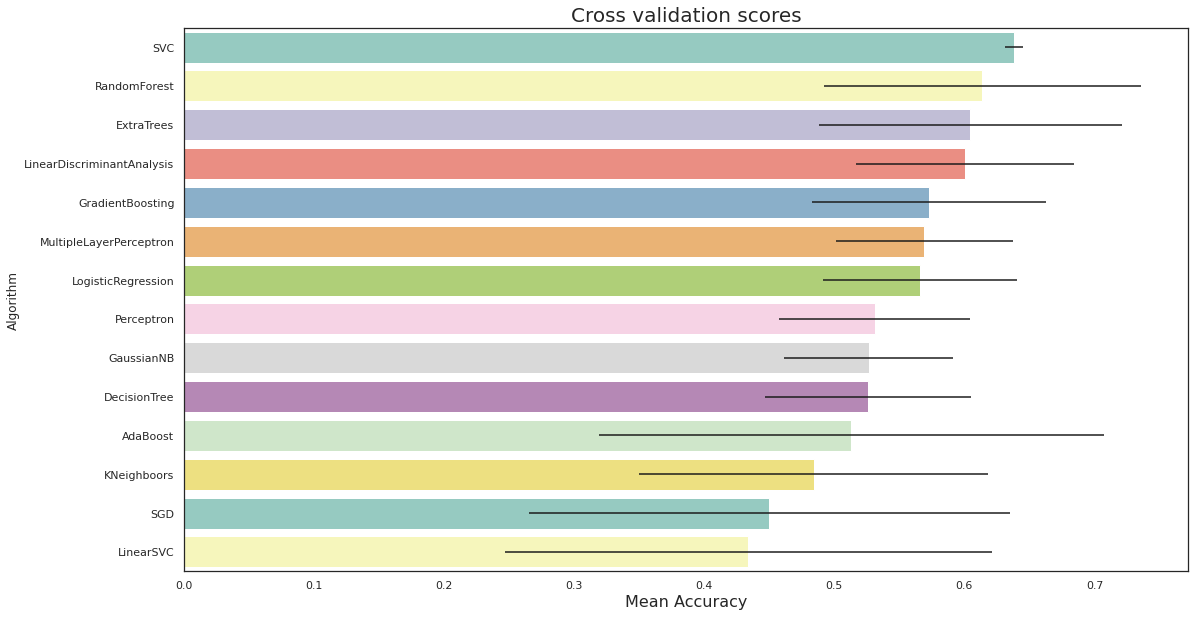

In [24]:
plt.figure(figsize=(18,10))
ax = sns.barplot("CVAccMeans","Algorithm",data=cv_res.sort_values(by='CVAccMeans', ascending=False), palette="Set3", orient="h", **{'xerr':cv_acc_std})
ax.set_xlabel("Mean Accuracy", size=16)
ax.set_title("Cross validation scores", size=20)

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Cross validation scores')

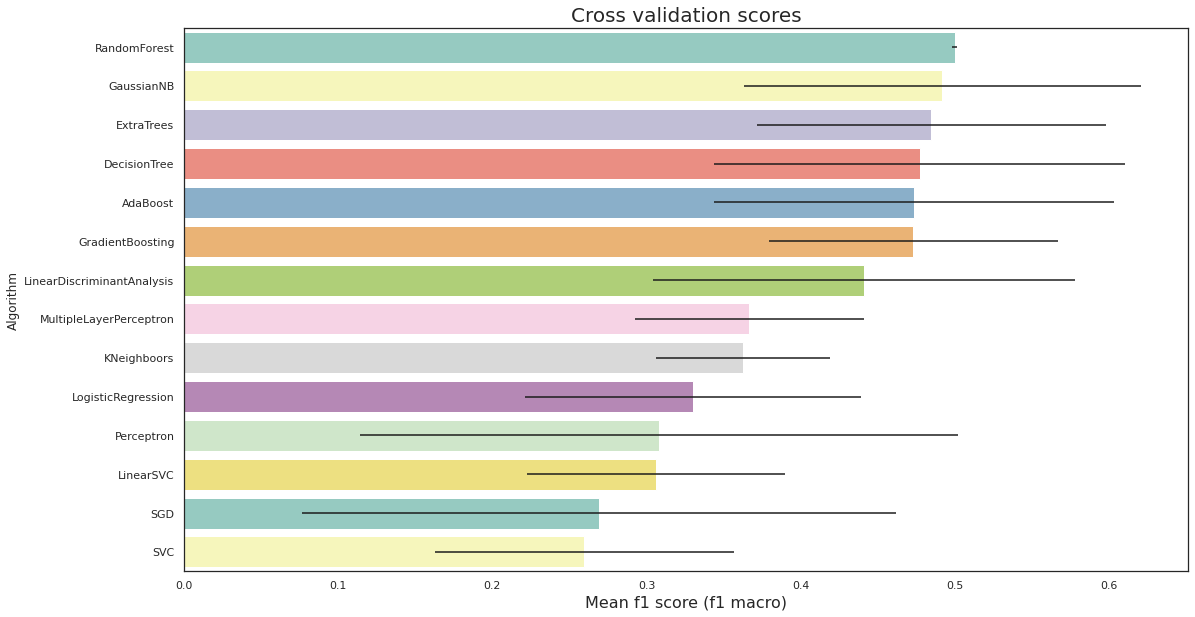

In [25]:
plt.figure(figsize=(18,10))
ax = sns.barplot("CVf1Means","Algorithm",data=cv_res.sort_values(by='CVf1Means', ascending=False), palette="Set3", orient="h", **{'xerr':cv_f1_std})
ax.set_xlabel("Mean f1 score (f1 macro)", size=16)
ax.set_title("Cross validation scores", size=20)

## Hyperparameter Tuning

In [26]:
def metric(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='macro')
    return acc, f1

scoring = {'Accuracy': 'accuracy', 'F1': 'f1_macro'}
refit = 'F1'

In [27]:
def train_grid_search(estimator, param_grid, scoring, refit, cv=5, verbose=1, plot=True):
    model = GridSearchCV(estimator, param_grid=param_grid, cv=cv, scoring=scoring, verbose=verbose, 
                         refit=refit, n_jobs=-1, return_train_score=True)
    model.fit(X_train, Y_train)
    
    results = model.cv_results_
    best_estimator = model.best_estimator_
    train_scores = results['mean_train_' + refit]
    test_scores = results['mean_test_' + refit]
    train_time = results['mean_fit_time']
    
    print("Best Score: ", model.best_score_)
    print("Best Param: ", model.best_params_)
    
    pred_train = best_estimator.predict(X_train)
    pred_test = best_estimator.predict(X_test)

    acc, f1 = metric(Y_train, pred_train)
    logger.info('Training - acc: %.8f, f1: %.8f' % (acc, f1))
    acc, f1 = metric(Y_test, pred_test)
    logger.info('Test - acc: %.8f, f1: %.8f' % (acc, f1))
        
    if plot:
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
        fig.suptitle("GridSearchCV Result", fontsize=20)
        
        ax1.plot(train_scores, test_scores, 'bo')
        ax1.set_title("Train Score v.s. Test Score", fontsize=16)
        ax1.set_xlabel("Train Score")
        ax1.set_ylabel("Test Score")
        ax1.set_xlim(0, 1)
        ax1.set_ylim(0, 1)
        ax1.grid(True)
        
        x_param = list(param_grid.keys())[0]
        x_param_min = np.min(list(param_grid.values())[0])
        x_param_max = np.max(list(param_grid.values())[0])

        ax2.set_title("Score over the first param", fontsize=16)
        ax2.set_xlabel(x_param)
        ax2.set_ylabel("Score")
        ax2.set_xlim(x_param_min, x_param_max)
        ax2.set_ylim(0, 1)

        X_axis = np.array(results['param_' + x_param].data, dtype=float)

        for scorer, color in zip(sorted(scoring), ['r', 'g']):
            for sample, style in (('train', '--'), ('test', '-')):
                sample_score_mean = results['mean_%s_%s' % (sample, scorer)]
                sample_score_std = results['std_%s_%s' % (sample, scorer)]
                ax2.fill_between(X_axis, sample_score_mean - sample_score_std,
                                sample_score_mean + sample_score_std,
                                alpha=0.1 if sample == 'test' else 0, color=color)
                ax2.plot(X_axis, sample_score_mean, style, color=color,
                        alpha=1 if sample == 'test' else 0.7,
                        label="%s (%s)" % (scorer, sample.capitalize()))

            best_index = np.nonzero(results['rank_test_%s' % scorer] == 1)[0][0]
            best_score = results['mean_test_%s' % scorer][best_index]

            ax2.plot([X_axis[best_index], ] * 2, [0, best_score],
                    linestyle='-.', color=color, marker='x', markeredgewidth=3, ms=8)

            ax2.annotate("%0.2f" % best_score,
                        (X_axis[best_index], best_score + 0.005))

        ax2.legend(loc="best")
        ax2.grid(False)
        
        lc_acc_train_sizes, lc_acc_train_scores, lc_acc_test_scores = learning_curve(
            best_estimator, X_train, Y_train, cv=kfold, n_jobs=-1, scoring=scoring['Accuracy'], 
            train_sizes=np.linspace(.1, 1.0, 5))
        lc_acc_train_mean = np.mean(lc_acc_train_scores, axis=1)
        lc_acc_train_std = np.std(lc_acc_train_scores, axis=1)
        lc_acc_test_mean = np.mean(lc_acc_test_scores, axis=1)
        lc_acc_test_std = np.std(lc_acc_test_scores, axis=1)
        
        lc_f1_train_sizes, lc_f1_train_scores, lc_f1_test_scores = learning_curve(
            best_estimator, X_train, Y_train, cv=kfold, n_jobs=-1, scoring=scoring['F1'], 
            train_sizes=np.linspace(.1, 1.0, 5))
        lc_f1_train_mean = np.mean(lc_f1_train_scores, axis=1)
        lc_f1_train_std = np.std(lc_f1_train_scores, axis=1)
        lc_f1_test_mean = np.mean(lc_f1_test_scores, axis=1)
        lc_f1_test_std = np.std(lc_f1_test_scores, axis=1)
        
        ax3.set_title("Learning Curve", fontsize=16)
        ax3.set_xlabel("Training examples")
        ax3.set_ylabel("Score")

        ax3.fill_between(lc_acc_train_sizes, 
                         lc_acc_train_mean - lc_acc_train_std,
                         lc_acc_train_mean + lc_acc_train_std, alpha=0.1, color="r")
        ax3.fill_between(lc_acc_train_sizes, 
                         lc_acc_test_mean - lc_acc_test_std,
                         lc_acc_test_mean + lc_acc_test_std, alpha=0.1, color="r")
        ax3.plot(lc_acc_train_sizes, lc_acc_train_mean, 'o--', color="r",
                 label="Accuracy (Train)")
        ax3.plot(lc_acc_train_sizes, lc_acc_test_mean, 'o-', color="r",
                 label="Accuracy (Test)")
        
        ax3.fill_between(lc_f1_train_sizes, 
                         lc_f1_train_mean - lc_f1_train_std,
                         lc_f1_train_mean + lc_f1_train_std, alpha=0.1, color="g")
        ax3.fill_between(lc_f1_train_sizes, 
                         lc_f1_test_mean - lc_f1_test_std,
                         lc_f1_test_mean + lc_f1_test_std, alpha=0.1, color="g")
        ax3.plot(lc_f1_train_sizes, lc_f1_train_mean, 'o--', color="g",
                 label="F1 (Train)")
        ax3.plot(lc_f1_train_sizes, lc_f1_test_mean, 'o-', color="g",
                 label="F1 (Test)")

        ax3.legend(loc="best")
        ax3.grid(True)
        
        plt.tight_layout(pad=3.0)
        plt.show()
        
        class_names = ['Lower', 'Hold', 'Raise']
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
        fig.suptitle("Confusion Matrix", fontsize=20)
        
        plot_confusion_matrix(best_estimator, X_train, Y_train, display_labels=class_names, 
                              cmap=plt.cm.Blues, normalize=None, ax=ax1)
        ax1.set_title("Train Data: Actual Count")
        ax1.grid(False)
        
        plot_confusion_matrix(best_estimator, X_train, Y_train, display_labels=class_names, 
                              cmap=plt.cm.Blues, normalize='all', ax=ax2)
        ax2.set_title=("Train Data: Normalized")
        ax2.grid(False)
        
        plot_confusion_matrix(best_estimator, X_test, Y_test, display_labels=class_names, 
                              cmap=plt.cm.Blues, normalize=None, ax=ax3)
        ax3.set_title=("Test Data: Actual Count")
        ax3.grid(False)
        
        plot_confusion_matrix(best_estimator, X_test, Y_test, display_labels=class_names, 
                              cmap=plt.cm.Blues, normalize='all', ax=ax4)
        ax4.set_title("Test Data: Normalized")
        ax4.grid(False)
        
        plt.tight_layout(pad=3.0)
        plt.show()
    
    return model

### ADA Boost (on Decision Tree)

In [28]:
DTC = DecisionTreeClassifier()
ada_clf = AdaBoostClassifier(DTC, random_state=rand_seed)

In [29]:
rand_param_grid = {"base_estimator__criterion" : ["gini", "entropy"],
              "base_estimator__splitter" :   ["best", "random"],
              "algorithm" : ["SAMME","SAMME.R"],
              "n_estimators" : [10, 50, 100, 200, 500],
              "learning_rate":  [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 1.0, 1.5]}

rand_model = RandomizedSearchCV(estimator=ada_clf, param_distributions=rand_param_grid, 
                                 n_iter=300, cv=kfold, scoring=scoring[refit], verbose=1, 
                                 random_state=rand_seed, n_jobs=-1)
rand_model.fit(X_train,Y_train)
print(rand_model.best_score_)
print(rand_model.best_params_)

Fitting 7 folds for each of 300 candidates, totalling 2100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 312 tasks      | elapsed:    1.0s


0.48384574599440144
{'n_estimators': 500, 'learning_rate': 0.001, 'base_estimator__splitter': 'best', 'base_estimator__criterion': 'gini', 'algorithm': 'SAMME.R'}


[Parallel(n_jobs=-1)]: Done 2100 out of 2100 | elapsed:    4.6s finished


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 7 folds for each of 50 candidates, totalling 350 fits


[Parallel(n_jobs=-1)]: Done 238 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 350 out of 350 | elapsed:    1.1s finished
[2021-01-24 01:12:15,033][INFO] ## Training - acc: 1.00000000, f1: 1.00000000
[2021-01-24 01:12:15,036][INFO] ## Test - acc: 0.43750000, f1: 0.29121278


Best Score:  0.37360576621869923
Best Param:  {'algorithm': 'SAMME.R', 'base_estimator__criterion': 'gini', 'base_estimator__splitter': 'random', 'learning_rate': 0.01, 'n_estimators': 1}


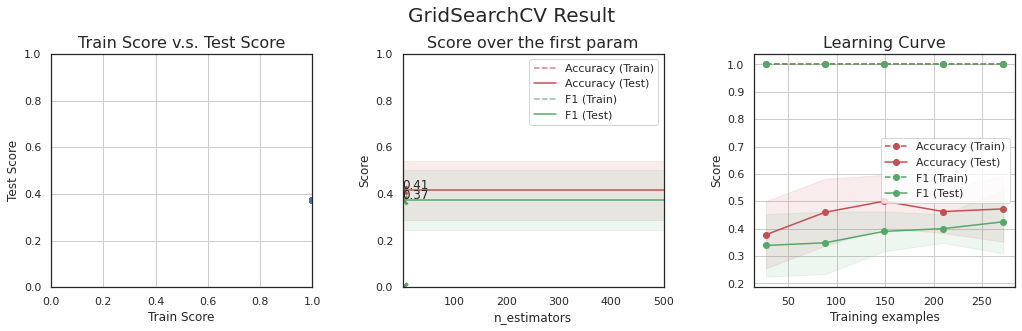

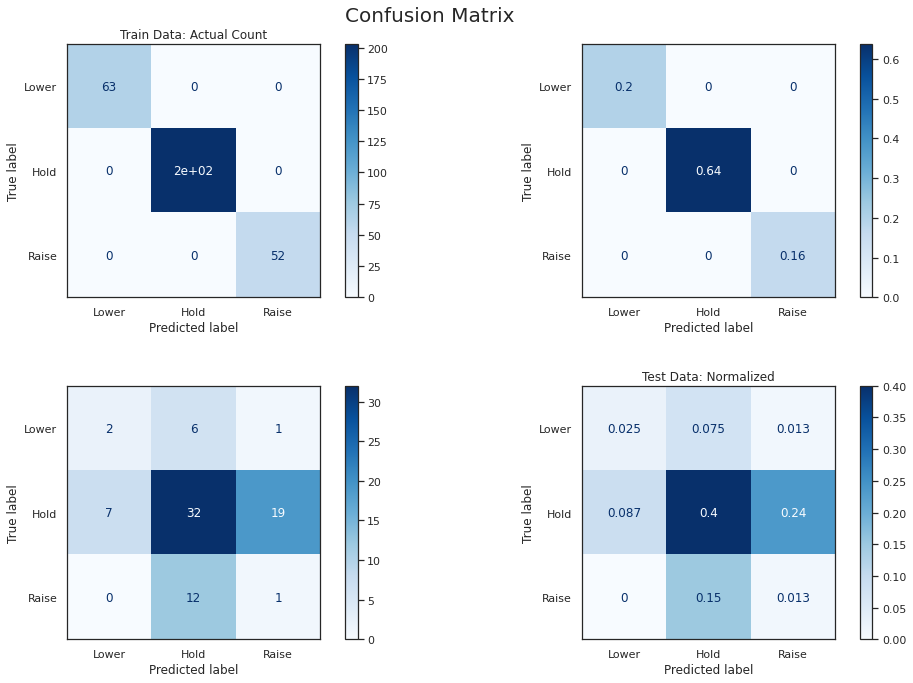

In [30]:
param_grid = {'n_estimators': np.linspace(1, 500, 50, dtype=int),
              'base_estimator__criterion': ['gini'],
              'base_estimator__splitter': ['random'],
              'algorithm': ['SAMME.R'],
              'learning_rate': [0.01]}

ada_model = train_grid_search(ada_clf, param_grid, scoring, refit, cv=kfold, verbose=1, plot=True)
ada_best = ada_model.best_estimator_

### Extra Tree

In [31]:
ext_clf = ExtraTreesClassifier()

rand_param_grid = {"max_depth": [None],
              "max_features": [1, 2, 3, 5],
              "min_samples_split": [2, 3, 5, 10, 20],
              "min_samples_leaf": [1, 3, 5, 7, 10],
              "bootstrap": [False],
              "n_estimators" : [1, 2, 5, 10, 20, 100, 200, 1000],
              "criterion": ["gini"]}

rand_model = RandomizedSearchCV(estimator=ext_clf, 
                                param_distributions=rand_param_grid, 
                                n_iter=300, 
                                cv=kfold, 
                                scoring=scoring[refit], 
                                verbose=1, 
                                random_state=rand_seed,
                                n_jobs=-1)
rand_model.fit(X_train,Y_train)
print(rand_model.best_score_)
print(rand_model.best_params_)

Fitting 7 folds for each of 300 candidates, totalling 2100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 356 tasks      | elapsed:   32.3s
[Parallel(n_jobs=-1)]: Done 840 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1520 tasks      | elapsed:  2.1min


0.5347775580862136
{'n_estimators': 1, 'min_samples_split': 2, 'min_samples_leaf': 10, 'max_features': 5, 'max_depth': None, 'criterion': 'gini', 'bootstrap': False}


[Parallel(n_jobs=-1)]: Done 2100 out of 2100 | elapsed:  2.8min finished


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 7 folds for each of 50 candidates, totalling 350 fits


[Parallel(n_jobs=-1)]: Done 200 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 350 out of 350 | elapsed:   10.6s finished
[2021-01-24 01:15:16,507][INFO] ## Training - acc: 0.68867925, f1: 0.56794476
[2021-01-24 01:15:16,510][INFO] ## Test - acc: 0.56250000, f1: 0.26229191


Best Score:  0.5435110438917591
Best Param:  {'bootstrap': False, 'criterion': 'gini', 'max_depth': None, 'max_features': 8, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1}


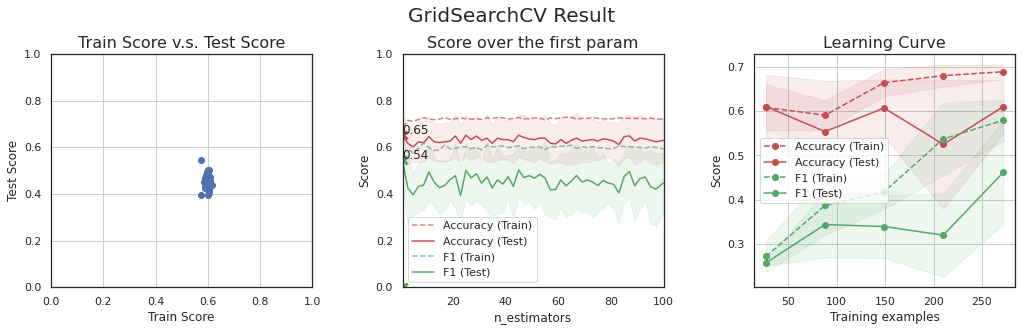

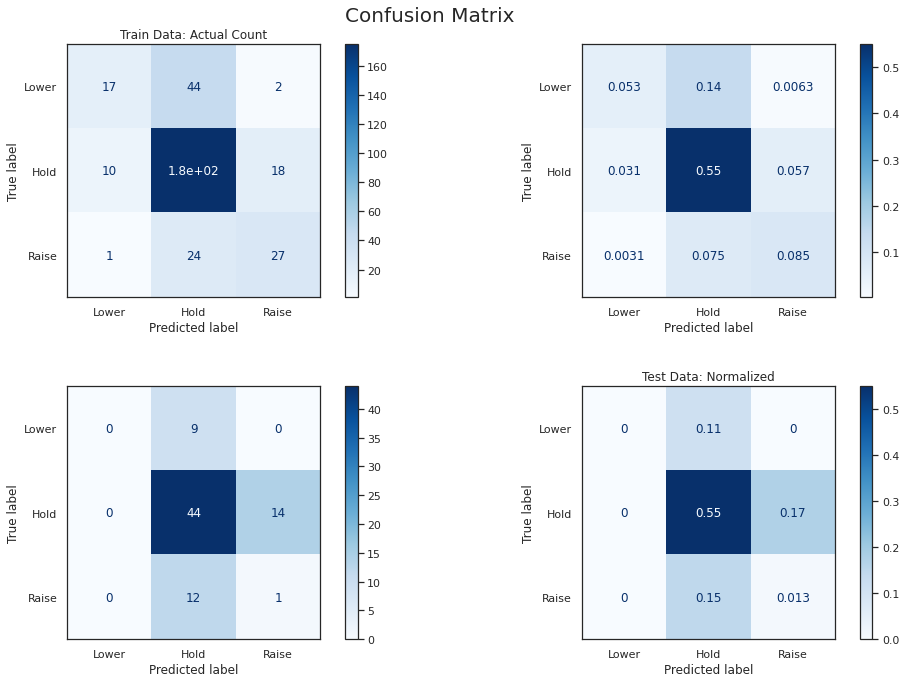

In [32]:
param_grid = {'n_estimators': np.linspace(1, 100, 50, dtype=int),
              'min_samples_split': [5],
              'min_samples_leaf': [10],
              'max_features': [8],
              'max_depth': [None],
              'criterion': ['gini'],
              'bootstrap': [False]}

ext_model = train_grid_search(ext_clf, param_grid, scoring, refit, cv=kfold, verbose=1, plot=True)
ext_best = ext_model.best_estimator_

### Random Forest

In [33]:
rf_clf = RandomForestClassifier()

rand_param_grid = {"max_depth": [None],
              "max_features": [1, 2, 3, 5],
              "min_samples_split": [2, 3, 5, 7, 10],
              "min_samples_leaf": [1, 3, 5, 7, 10, 15],
              "bootstrap": [False],
              "n_estimators" :[1, 2, 5, 10, 100, 200, 300, 500, 1000],
              "criterion": ["gini"]}

rand_model = RandomizedSearchCV(estimator=rf_clf, 
                                param_distributions=rand_param_grid, 
                                n_iter=300, 
                                cv=kfold, 
                                scoring=scoring[refit], 
                                verbose=1, 
                                 random_state=rand_seed, n_jobs=-1)
rand_model.fit(X_train,Y_train)
print(rand_model.best_score_)
print(rand_model.best_params_)

Fitting 7 folds for each of 300 candidates, totalling 2100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed:   33.4s
[Parallel(n_jobs=-1)]: Done 650 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 1212 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 1786 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 2093 out of 2100 | elapsed:  4.5min remaining:    0.9s


0.5473343035613482
{'n_estimators': 1, 'min_samples_split': 5, 'min_samples_leaf': 15, 'max_features': 5, 'max_depth': None, 'criterion': 'gini', 'bootstrap': False}


[Parallel(n_jobs=-1)]: Done 2100 out of 2100 | elapsed:  4.6min finished


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 7 folds for each of 50 candidates, totalling 350 fits


[Parallel(n_jobs=-1)]: Done 119 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:   44.8s
[Parallel(n_jobs=-1)]: Done 350 out of 350 | elapsed:  1.2min finished
[2021-01-24 01:21:07,292][INFO] ## Training - acc: 0.93081761, f1: 0.91353213
[2021-01-24 01:21:07,294][INFO] ## Test - acc: 0.62500000, f1: 0.50148544


Best Score:  0.5165161304788055
Best Param:  {'bootstrap': False, 'criterion': 'gini', 'max_depth': None, 'max_features': 8, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 72}


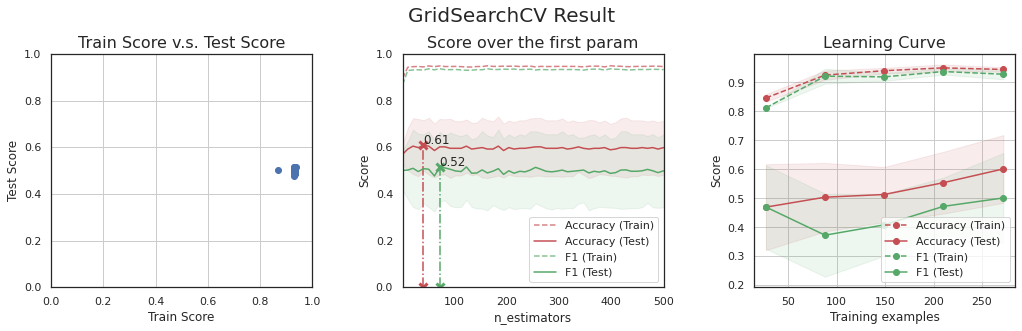

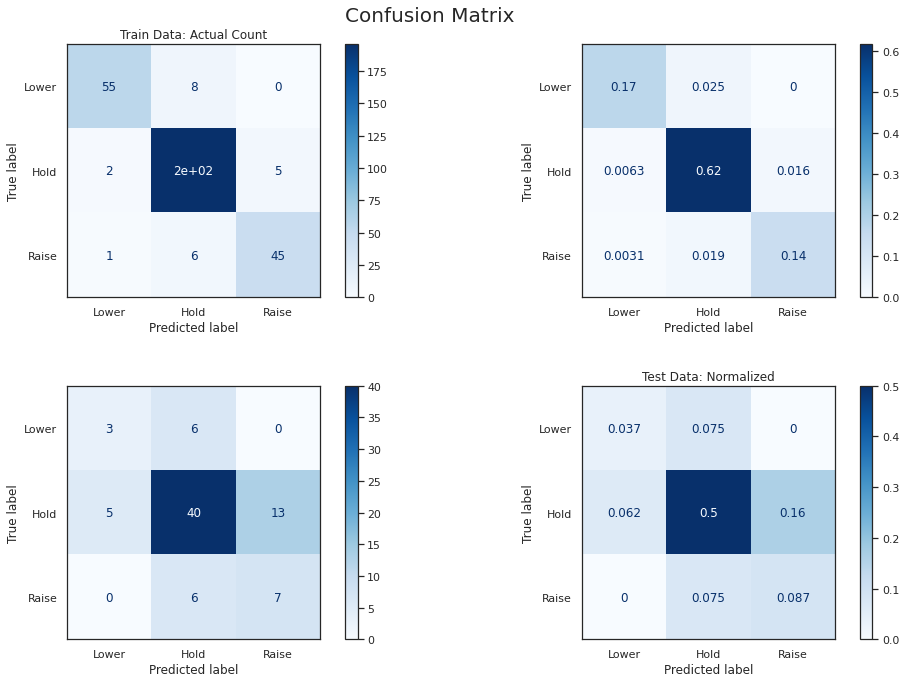

In [34]:
param_grid = {'n_estimators': np.linspace(1, 500, 50, dtype=int),
              'min_samples_split': [2],
              'min_samples_leaf': [3],
              'max_features': [8],
              'max_depth': [None],
              'criterion': ['gini'],
              'bootstrap': [False]}

rf_model = train_grid_search(rf_clf, param_grid, scoring, refit, cv=kfold, verbose=1, plot=True)
rf_best = rf_model.best_estimator_

### Gradient Boosting

In [35]:
gb_clf = GradientBoostingClassifier()

rand_param_grid = {
    'loss' : ["deviance"],
    'n_estimators' : [1, 10, 100, 200, 300, 1000],
    'learning_rate': [0.1, 0.05, 0.01, 0.005],
    'max_depth': [2, 4, 6, 8, 10],
    'min_samples_leaf': [2, 5, 10, 15, 20, 30, 50, 100, 200, 300],
    'max_features': [0.8, 0.6, 0.4, 0.2, 0.1]
    }

rand_model = RandomizedSearchCV(estimator=gb_clf, 
                                param_distributions=rand_param_grid, 
                                n_iter=300, 
                                cv=kfold, 
                                scoring=scoring[refit], 
                                verbose=1, 
                                random_state=rand_seed, 
                                n_jobs=-1)

rand_model.fit(X_train,Y_train)
print(rand_model.best_score_)
print(rand_model.best_params_)

Fitting 7 folds for each of 300 candidates, totalling 2100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:   37.6s
[Parallel(n_jobs=-1)]: Done 200 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 462 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 824 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 1330 tasks      | elapsed:  7.6min
[Parallel(n_jobs=-1)]: Done 1880 tasks      | elapsed: 10.2min
[Parallel(n_jobs=-1)]: Done 2093 out of 2100 | elapsed: 11.4min remaining:    2.3s
[Parallel(n_jobs=-1)]: Done 2100 out of 2100 | elapsed: 11.5min finished


0.5340023766716401
{'n_estimators': 100, 'min_samples_leaf': 15, 'max_features': 0.6, 'max_depth': 2, 'loss': 'deviance', 'learning_rate': 0.1}


Fitting 7 folds for each of 50 candidates, totalling 350 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 110 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done 260 tasks      | elapsed:   46.5s
[Parallel(n_jobs=-1)]: Done 350 out of 350 | elapsed:  1.4min finished
[2021-01-24 01:34:04,916][INFO] ## Training - acc: 0.79874214, f1: 0.73008605
[2021-01-24 01:34:04,919][INFO] ## Test - acc: 0.68750000, f1: 0.37882765


Best Score:  0.5275099471869592
Best Param:  {'learning_rate': 0.05, 'loss': 'deviance', 'max_depth': 2, 'max_features': 0.6, 'min_samples_leaf': 15, 'n_estimators': 92}


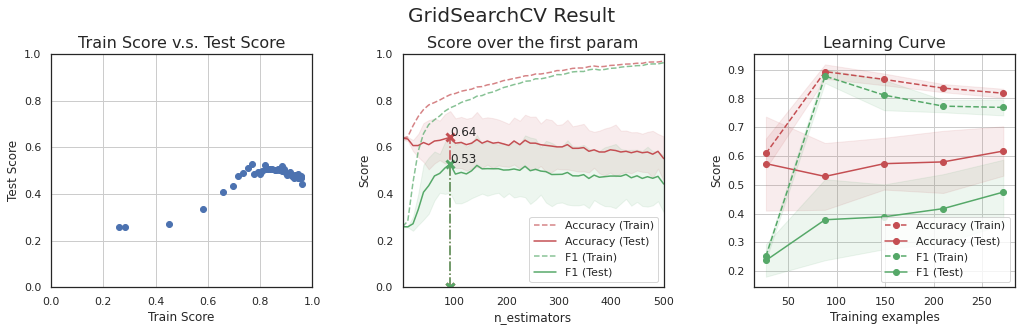

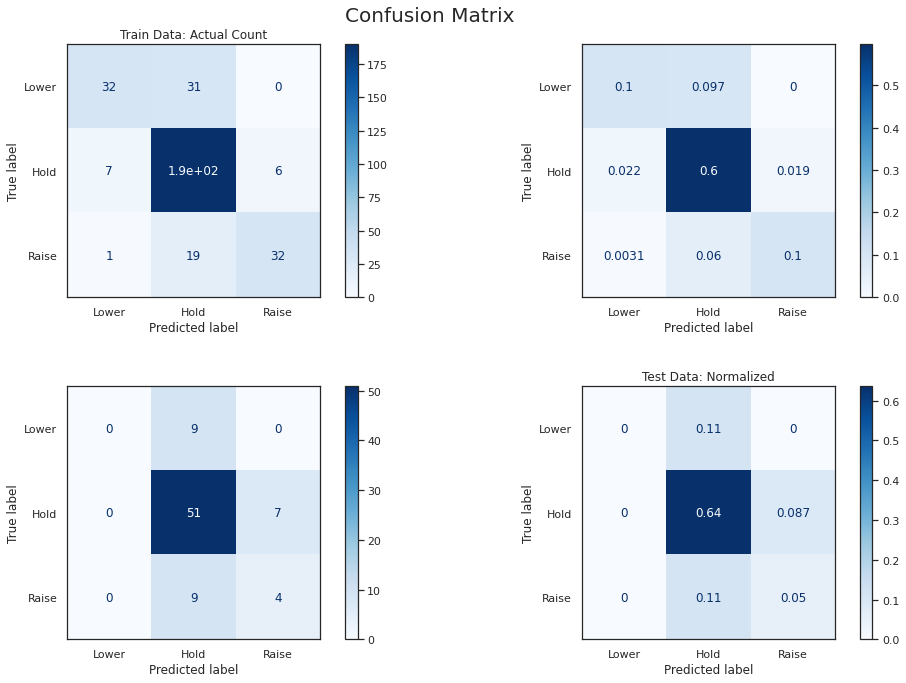

In [36]:
param_grid = {'n_estimators': np.linspace(1, 500, 50, dtype=int),
              'min_samples_leaf': [15],
              'max_features': [0.6],
              'max_depth': [2],
              'loss': ['deviance'],
              'learning_rate': [0.05]}

gb_model = train_grid_search(gb_clf, 
                             param_grid, 
                             scoring, 
                             refit, 
                             cv=kfold, 
                             verbose=1, 
                             plot=True)

gb_best = gb_model.best_estimator_

### SVM

In [37]:
svm_clf = SVC(probability=True)

rand_param_grid = {'kernel': ['rbf'], 
                  'gamma': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1],
                  'C': [1, 2, 3, 5, 8, 10, 50, 100, 200, 300, 500, 1000]}

rand_model = RandomizedSearchCV(estimator=svm_clf, 
                                param_distributions=rand_param_grid, 
                                n_iter=300, 
                                cv=kfold, 
                                scoring=scoring[refit], 
                                verbose=1, 
                                random_state=rand_seed, 
                                n_jobs=-1)

rand_model.fit(X_train,Y_train)
print(rand_model.best_score_)
print(rand_model.best_params_)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 84 is smaller than n_iter=300. Running 84 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 7 folds for each of 84 candidates, totalling 588 fits


[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    1.7s


0.4645510437396955
{'kernel': 'rbf', 'gamma': 0.001, 'C': 100}


[Parallel(n_jobs=-1)]: Done 581 out of 588 | elapsed:    7.8s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 588 out of 588 | elapsed:    7.8s finished


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 7 folds for each of 50 candidates, totalling 350 fits


[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 343 out of 350 | elapsed:    5.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 350 out of 350 | elapsed:    5.1s finished
[2021-01-24 01:34:25,548][INFO] ## Training - acc: 0.83018868, f1: 0.77562130
[2021-01-24 01:34:25,551][INFO] ## Test - acc: 0.62500000, f1: 0.37328491


Best Score:  0.42960685147685435
Best Param:  {'C': 10, 'gamma': 0.0021387755102040816, 'kernel': 'rbf'}


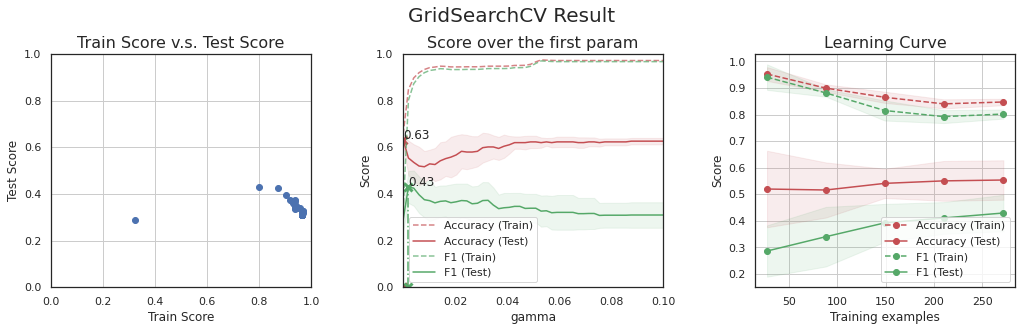

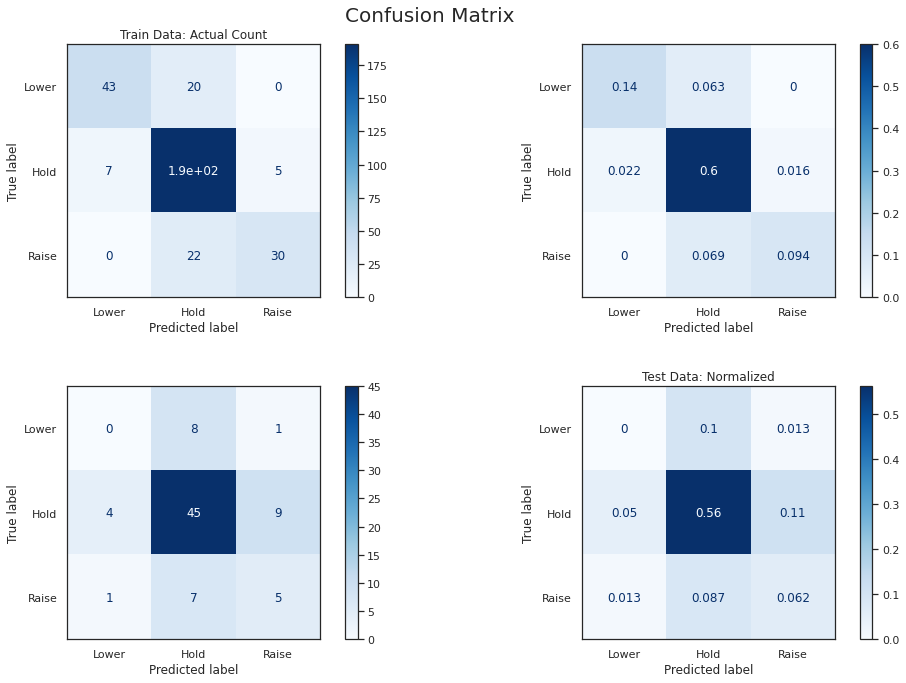

In [38]:
param_grid = {'gamma': np.linspace(0.0001, 0.1, 50, dtype=float),
              'C': [10],
              'kernel': ['rbf']}

svm_model = train_grid_search(svm_clf, 
                              param_grid, 
                              scoring, 
                              refit, 
                              cv=kfold, 
                              verbose=1, 
                              plot=True)

svm_best = svm_model.best_estimator_

### Feature Importance
Check feature importance on four tree-based classifiers out of ten.

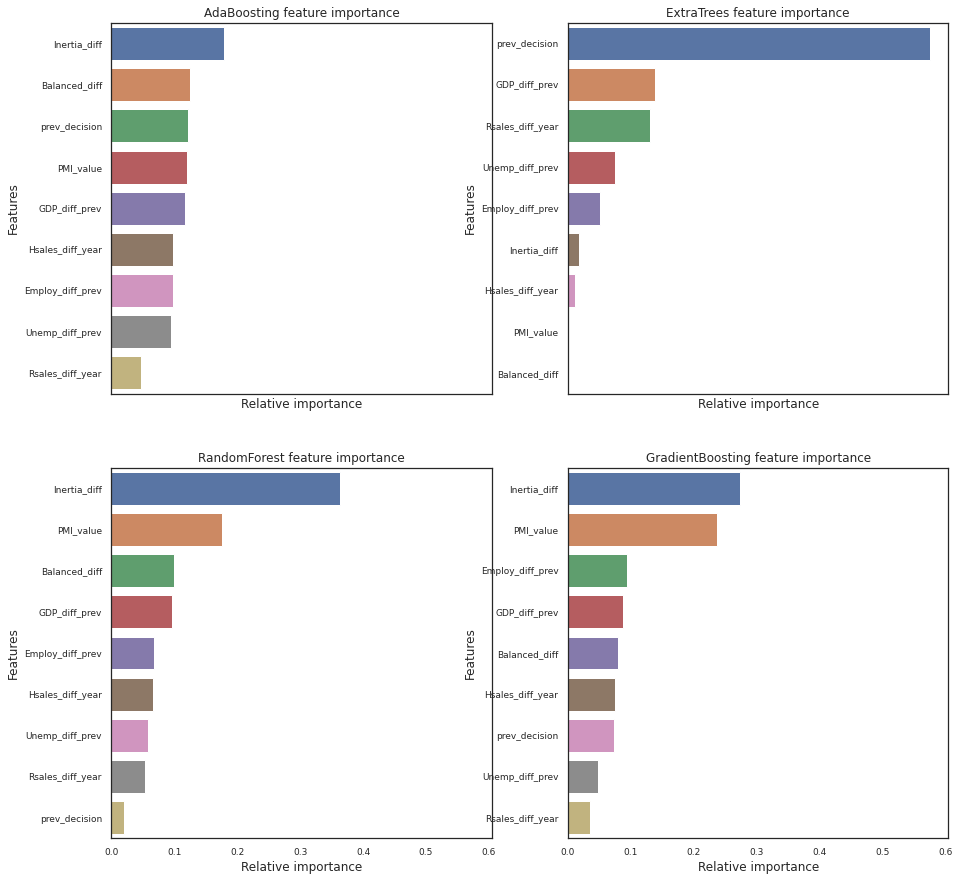

In [39]:
nrows = ncols = 2
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, sharex="all", figsize=(15,15))

names_classifiers = [("AdaBoosting", ada_best), 
                     ("ExtraTrees", ext_best), 
                     ("RandomForest", rf_best), 
                     ("GradientBoosting",gb_best)]

nclassifier = 0
for row in range(nrows):
    for col in range(ncols):
        name = names_classifiers[nclassifier][0]
        classifier = names_classifiers[nclassifier][1]
        indices = np.argsort(classifier.feature_importances_)[::-1][:40]
        g = sns.barplot(y=X_balanced.columns[indices][:40], x=classifier.feature_importances_[indices][:40] , orient='h',ax=axes[row][col])
        g.set_xlabel("Relative importance",fontsize=12)
        g.set_ylabel("Features",fontsize=12)
        g.tick_params(labelsize=9)
        g.set_title(name + " feature importance")
        nclassifier += 1

## Ensembling

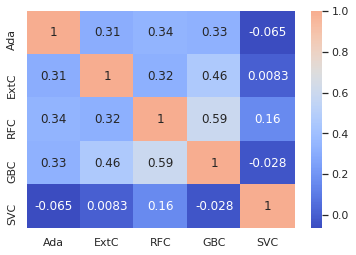

In [40]:
test_ada = pd.Series(ada_best.predict(X_test), name="Ada")
test_ext = pd.Series(ext_best.predict(X_test), name="ExtC")
test_rf = pd.Series(rf_best.predict(X_test), name="RFC")
test_gb = pd.Series(gb_best.predict(X_test), name="GBC")
test_svm = pd.Series(svm_best.predict(X_test), name="SVC")

ensemble_results = pd.concat([test_ada, test_ext, test_rf, test_gb, test_svm],axis=1)

g = sns.heatmap(ensemble_results.corr(),annot=True, cmap="coolwarm", center=0.7)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


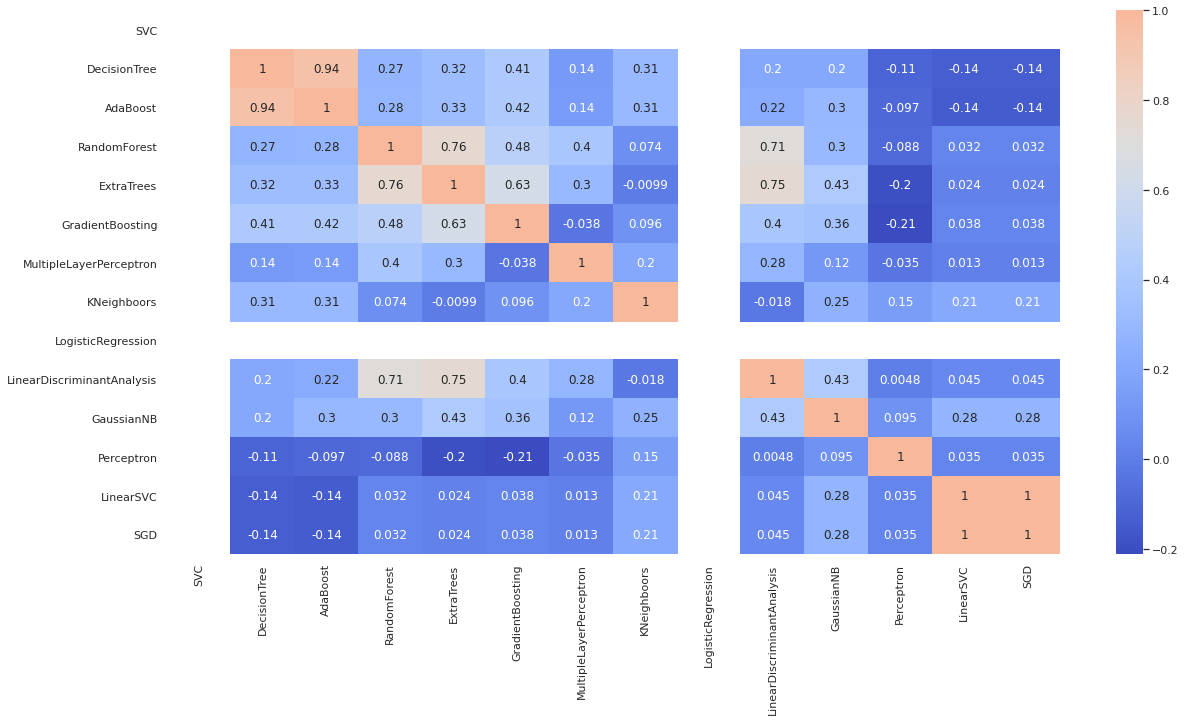

In [41]:
test_resuts = []

for classifier in classifiers:
    estimator = classifier[1].fit(X_train, Y_train)
    test_resuts.append(pd.Series(estimator.predict(X_test), name=classifier[0]))

base_results = pd.concat(test_resuts, axis=1)

plt.figure(figsize=(20,10))
g = sns.heatmap(base_results.corr(),annot=True, cmap="coolwarm", center=0.7)

### Voting Classifier

In [42]:
voting_best = VotingClassifier(estimators=[('adac', ada_best),
                                           ('extc', ext_best), 
                                           ('rfc', rf_best), 
                                           ('gbc', gb_best), 
                                           ('svmc', svm_best)], voting='soft', n_jobs=-1)

voting_best.fit(X_train, Y_train)

VotingClassifier(estimators=[('adac',
                              AdaBoostClassifier(algorithm='SAMME.R',
                                                 base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                                                       class_weight=None,
                                                                                       criterion='gini',
                                                                                       max_depth=None,
                                                                                       max_features=None,
                                                                                       max_leaf_nodes=None,
                                                                                       min_impurity_decrease=0.0,
                                                                                       min_impurity_split=None,
                                    

In [43]:
voting_pred_train = voting_best.predict(X_train)
voting_pred_test = voting_best.predict(X_test)

acc, f1 = metric(Y_train, voting_pred_train)
logger.info('Training - acc: %.8f, f1: %.8f' % (acc, f1))

acc, f1 = metric(Y_test, voting_pred_test)
logger.info('Test - acc: %.8f, f1: %.8f' % (acc, f1))

[2021-01-24 01:34:32,895][INFO] ## Training - acc: 0.94339623, f1: 0.92991002
[2021-01-24 01:34:32,897][INFO] ## Test - acc: 0.62500000, f1: 0.31076389


### Stacking by XGBoost

In [44]:
X_test_s = pd.DataFrame(X_test)
X_test_stacked = pd.concat([X_test_s, X_test_s, X_test_s, X_test_s, X_test_s], axis=0)
pred_test_stacked = pd.concat([test_ada, test_ext, test_rf, test_gb, test_svm],axis=0)
X_test_s = X_test_s
X_test_stacked = X_test_stacked
pred_test_stacked = pred_test_stacked
print(X_test_s)
print(X_test_stacked)
print(pred_test_stacked)

     0          1     2      3  ...          5          6        7           8
0    0   0.714973  56.6  168.5  ... -0.0333333          0 -17.4803           0
1    0   0.714973  52.9    148  ...  0.0333333          0 -14.5022           0
2    0   0.714973    53     93  ...          0          0 -11.2885           0
3   -1 -0.0277787  52.8  179.5  ...  0.0333333          0 -10.1406           0
4    0 -0.0277787  51.8  218.5  ...  0.0666667          0 -7.21511           0
..  ..        ...   ...    ...  ...        ...        ...      ...         ...
75  -1   0.527469  50.1  232.5  ...          0 -0.0580848  13.9109  0.00427873
76  -1   0.527469  50.1  232.5  ...          0 -0.0571394  13.9109  0.00142624
77   0   0.527469  50.1  232.5  ...          0 -0.0571394  13.9109  0.00142624
78   0   0.527469  50.1  232.5  ...          0  -0.114279  13.9109  0.00609178
79   0   0.527469  49.1   -561  ...       -0.3   -0.43152  12.4683   0.0402949

[80 rows x 9 columns]
     0          1     2      

In [45]:
#gbm = xgb.XGBClassifier(
#    n_estimator = 2000, 
#    max_depth = 4, 
#    min_child_weight = 2, 
#    gamma = 0.9, 
#    subsample = 0.8, 
#    colsample_bytree = 0.8, 
#    objective = 'binary:logistic', 
#    nthread = -1, 
#    scale_pos_weight = 1).fit(X_test_stacked, pred_test_stacked)
#
# Predict
#gbm_pred_train = gbm.predict(pd.DataFrame(X_train.astype(str)))
#gbm_pred_test = gbm.predict(X_test_s)
#acc, f1 = metric(Y_train, gbm_pred_train)
#logger.info('Test - acc: %.8f, f1: %.8f' % (acc, f1))
#acc, f1 = metric(Y_test, gbm_pred_test)
#logger.info('Test - acc: %.8f, f1: %.8f' % (acc, f1))

## Result

In [46]:
result_clf = [('AdaDTC', ada_best),
              ('ExtraTree', ext_best), 
              ('RandomForest', rf_best),
              ('GradientBoost', gb_best), 
              ('SVM', svm_best),
              ('Voting', voting_best)]

results = []

for clf in result_clf:
    pred_train = clf[1].predict(pd.DataFrame(X_train))
    pred_test = clf[1].predict(pd.DataFrame(X_test))
    train_acc, train_f1 = metric(Y_train, pred_train)
    test_acc, test_f1 = metric(Y_test, pred_test)
    results.append((clf[0], 
                    train_acc, 
                    train_f1, 
                    test_acc, 
                    test_f1))

result_df = pd.DataFrame(results, columns=[
                                           'Classifier', 
                                           'Train Accuracy', 
                                           'Train F1', 
                                           'Test Accuracy', 
                                           'Test F1'
                                           ]
                         )
result_df

,Classifier,Train Accuracy,Train F1,Test Accuracy,Test F1
0,AdaDTC,1.000000,1.000000,0.4375,0.291213
1,ExtraTree,0.688679,0.567945,0.5625,0.262292
2,RandomForest,0.930818,0.913532,0.6250,0.501485
3,GradientBoost,0.798742,0.730086,0.6875,0.378828
4,SVM,0.830189,0.775621,0.6250,0.373285
5,Voting,0.943396,0.929910,0.6250,0.310764


In [47]:
baseline_model = rf_best
pred_test = baseline_model.predict(pd.DataFrame(X_test))
prediction_df = pd.concat([pd.Series(balanced.index.values), pd.Series(pred_test, name="Predict")],axis=1)

## Save the Data

In [48]:
if IN_COLAB:
  def save_data(df, file_name, dir_name=preprocessed_dir, index_csv=True):
    if not os.path.exists(dir_name):
      os.mkdir(dir_name)
    # Save results to a picke file
    file = open(dir_name + file_name + '.pickle', 'wb')
    pickle.dump(df, file)
    file.close()
    print('Successfully saved {}.pickle. in {}'.format(file_name, dir_name + file_name + '.pickle'))
    # Save results to a csv file
    df.to_csv(dir_name + file_name + '.csv', index=True)
    print('Successfully saved {}.csv. in {}'.format(file_name, dir_name + file_name + '.csv'))

else:
  def save_data(df, file_name, dir_name=preprocessed_dir):
    # Save results to a .picke file
    file = open(dir_name + file_name + '.pickle', 'wb')
    pickle.dump(df, file)
    file.close()
    print('Successfully saved {}.pickle. in {}'.format(file_name, dir_name + file_name + '.pickle'))
    # Save results to a .csv file
    df.to_csv(dir_name + file_name + '.csv', index=True)
    print('Successfully saved {}.csv. in {}'.format(file_name, dir_name + file_name + '.csv'))

In [49]:
# Save result
save_data(result_df, "result_scores", output_dir, index_csv=False)
save_data(prediction_df, "baseline_predictions", output_dir, index_csv=False)
save_data(X_balanced, "training_data", output_dir, index_csv=True)

Successfully saved result_scores.pickle. in /content/drive/My Drive/Colab Notebooks/proj2/src/data/result/result_scores.pickle
Successfully saved result_scores.csv. in /content/drive/My Drive/Colab Notebooks/proj2/src/data/result/result_scores.csv
Successfully saved baseline_predictions.pickle. in /content/drive/My Drive/Colab Notebooks/proj2/src/data/result/baseline_predictions.pickle
Successfully saved baseline_predictions.csv. in /content/drive/My Drive/Colab Notebooks/proj2/src/data/result/baseline_predictions.csv
Successfully saved training_data.pickle. in /content/drive/My Drive/Colab Notebooks/proj2/src/data/result/training_data.pickle
Successfully saved training_data.csv. in /content/drive/My Drive/Colab Notebooks/proj2/src/data/result/training_data.csv
